# Receiver Operating Characteristic Curves

In Data Science, evaluating model performance is very important and the most commonly used performance metric is the classification score. However, when dealing with fraud datasets with heavy class imbalance, a classification score does not make much sense. Instead, Receiver Operating Characteristic or ROC curves offer a better alternative. ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). The model performance is determined by looking at the area under the ROC curve (or AUC). The best possible AUC is 1 while the worst is 0.5 (the 45 degrees random line). Any value less than 0.5 means we can simply do the exact opposite of what the model recommends to get the value back above 0.5.

## Probability Distribution of Classes
First off, let us assume that our hypothetical model produced some probabilities for predicting the class of each record. As with most binary fraud models, let’s assume our classes are ‘good’ and ‘bad’ and the model produced probabilities of P(X=‘bad’). To create this, probability distribution, we plot a Gaussian distribution with different mean values for each class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,0.1,0.4)
bad_pdf = pdf(x,0.1,0.6)

In [3]:
# function to plot distribution
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

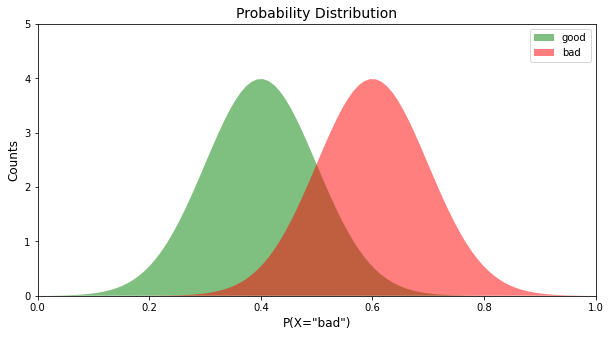

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

## Deriving ROC Curve
To derive the ROC curve from the probability distribution, we need to calculate the True Positive Rate (TPR) and False Positive Rate (FPR). For a simple example, let’s assume the threshold is at P(X=‘bad’)=0.6 .

True positive is the area designated as “bad” on the right side of the threshold. False positive denotes the area designated as “good” on the right of the threshold. Total positive is the total area under the “bad” curve while total negative is the total area under the “good” curve. We divide the value as shown in the diagram to derive TPR and FPR. We derive the TPR and FPR at different threshold values to get the ROC curve. Using this knowledge, we create the ROC plot function:

In [5]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/100
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

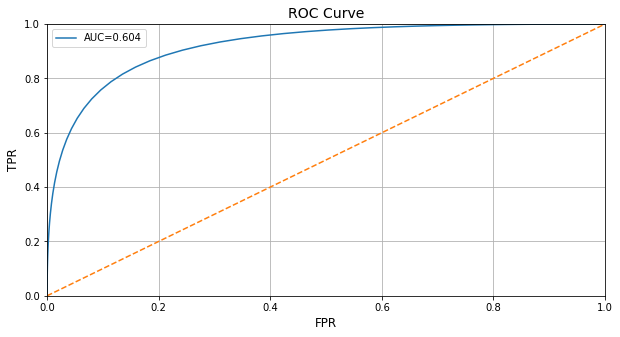

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_roc(good_pdf, bad_pdf, ax)

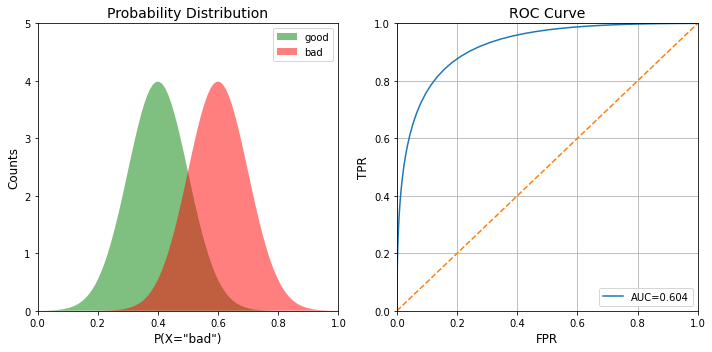

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax[0])
plot_roc(good_pdf, bad_pdf, ax[1])
plt.tight_layout()

## Effect of Class Separation
Now that we can derive both plots, let’s see how the ROC curve changes as the class separation (i.e. the model performance) improves. We do this by altering the mean value of the Gaussian in the probability distributions.

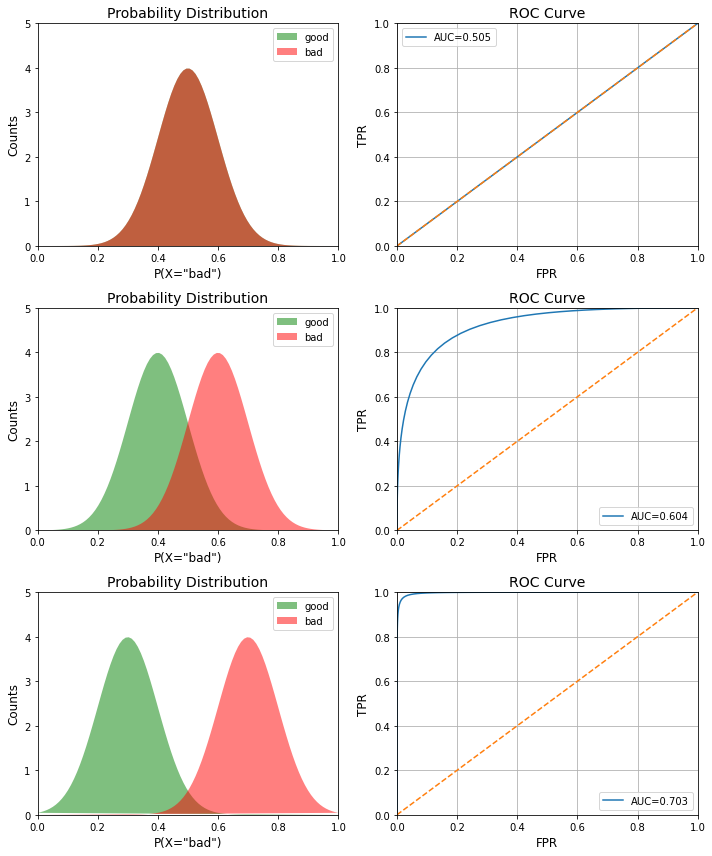

In [8]:
x = np.linspace(0, 1, num=100)
fig, ax = plt.subplots(3,2, figsize=(10,12))
means_tuples = [(0.5,0.5),(0.4,0.6),(0.3,0.7)]
i=0
for good_mean, bad_mean in means_tuples:
    good_pdf = pdf(x, 0.1, good_mean)
    bad_pdf  = pdf(x, 0.1, bad_mean)
    plot_pdf(good_pdf, bad_pdf, ax[i,0])
    plot_roc(good_pdf, bad_pdf, ax[i,1])
    i+=1
plt.tight_layout()

## another example code

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


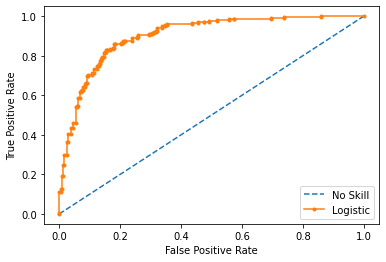

In [9]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Precision-Recall Curve



Logistic: f1=0.841 auc=0.898


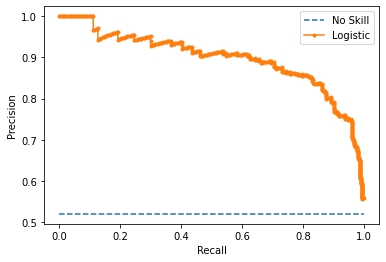

In [10]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## When to Use ROC vs. Precision-Recall Curves?

Generally, the use of ROC curves and precision-recall curves are as follows:

* ROC curves should be used when there are roughly equal numbers of observations for each class.
* Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

**Summary**

* ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
* Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
* ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.